In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
#export
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import gc
import random
import multiprocessing as mp
from fastai import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.tabular import *
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from KlsAutoencoder import wing

### Load ksent vectors of random genome samples of 16kb

In [14]:
runs = [
    pd.read_pickle("/home/serge/development/fastai-genomic/data/ksent_vectors_baccilium_top3_500_samples_per_fasta.pkl"),
    pd.read_pickle("/home/serge/development/fastai-genomic/data/ksent_vectors_baccilium_top3_500_samples_per_fasta_run2.pkl"),
    pd.read_pickle("/home/serge/development/fastai-genomic/data/ksent_vectors_baccilium_1000_samples_per_fasta.pkl"),
    pd.read_pickle("/home/serge/development/fastai-genomic/data/ksent_vectors_baccilium_1000_samples_per_fasta_run2.pkl")
]
df = pd.concat(runs)
df = df.sample(frac=1).reset_index()
df.head()

,spicies,ksent
0,velezensis,"[-0.12295379489660263, 0.07462853193283081, 0...."
1,subtilis,"[-0.12792307138442993, 0.05109456181526184, 0...."
2,subtilis,"[-0.051958564668893814, 0.0708932876586914, 0...."
3,anthracis,"[-0.009757889434695244, 0.10365800559520721, 0..."
4,anthracis,"[0.02173755131661892, 0.13600261509418488, 0.2..."


### Create Dataset

In [15]:
valid_idx = random.sample(range(df.shape[0]), int(np.floor(df.shape[0]* 0.2)))

db = (ItemList.from_df(df,cols="ksent").
      split_by_idx(valid_idx).
      label_from_df(cols="spicies").
      databunch())

### Create Model

In [16]:
def submodel(dims, bias=False):
    layer_dims = list(zip(dims[:-1],dims[1:]))
    fcl = [nn.Linear(*x, bias=bias) for x in layer_dims]
    [nn.init.xavier_uniform_(m.weight) for m in fcl]
    if bias: 
        for l in fcl: l.bias.data.normal_(0, 1)
    relu = [nn.ReLU() for _ in range(len(fcl))]
    layers = np.asarray(list(zip(fcl, relu))).ravel()[:-1]
    return nn.Sequential(*layers)


In [17]:
class Classifier (nn.Module):

    def __init__(self, encoder_dims, classifier_dims):
        super().__init__()
        self.encoder = submodel(encoder_dims,bias=True)
        self.classifier = submodel(classifier_dims,bias=True)


    def forward(self, x):
        x = self.encoder(x)
        return F.softmax(self.classifier(x), dim=1)

    def save_encoder(self,file:PathOrStr):
        torch.save(self.encoder.state_dict(), path)


In [23]:
model = Classifier([100,50,3,2], [2,20,3]).double()

In [24]:
model

Classifier(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=2, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=3, bias=True)
  )
)

### Learner

In [25]:
learn = Learner(db, model,metrics=[accuracy])
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


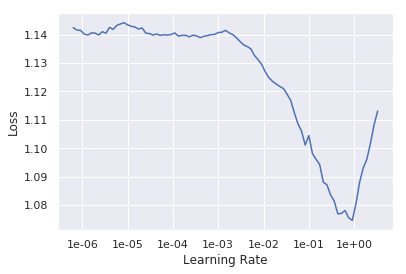

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.590244,0.594548,0.956413,00:33
1,0.602938,0.613712,0.937152,00:33
2,0.602362,0.587228,0.964116,00:33
3,0.608560,0.599983,0.951609,00:33
4,0.595172,0.584757,0.966449,00:33
5,0.594512,0.593186,0.958007,00:33
6,0.591562,0.617614,0.934464,00:33
7,0.585563,0.581127,0.970116,00:33
8,0.582352,0.580348,0.970891,00:33
9,0.579661,0.579660,0.971674,00:33


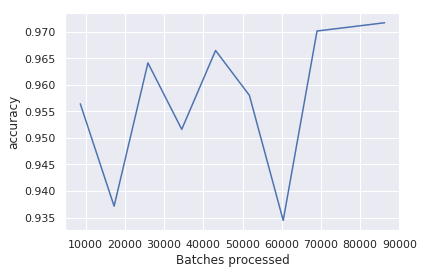

In [29]:
learn.recorder.plot_metrics()

In [30]:
interpretation = learn.interpret()

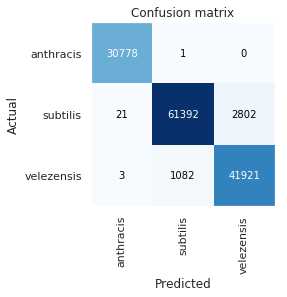

In [31]:
interpretation.plot_confusion_matrix()